In [1]:
print('start')

start


In [2]:
!python --version
!pip --version

Python 3.10.12
pip 23.1.2 from /opt/conda/lib/python3.10/site-packages/pip (python 3.10)


In [3]:
!pip install labml_helpers --quiet
!pip install labml_nn --quiet
!pip install torch-summary --quiet

!pip install diffusers --quiet

In [5]:
import math
import random
import os
from typing import Optional, Tuple, Union, List

import numpy as np
import matplotlib.pyplot as plt
import PIL

import torch
import torchvision
from torchsummary import summary
from torch import nn
import torch.nn.functional as F
import torch.utils.data

from diffusers import AutoencoderKL

from labml_helpers.module import Module
from labml_nn.diffusion.ddpm.utils import gather

import gc

---

In [6]:
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 123
IMG_SIZE = 64
BATCH_SIZE, DEVICE, SEED

(32, device(type='cuda'), 123)

In [8]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(SEED)

### Data-Preparation

In [9]:
from datasets import load_dataset

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

Downloading:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/huggan--smithsonian_butterflies_subset-7665b1021a37404c/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


In [10]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [11]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

In [12]:
dataloader_ = torch.utils.data.DataLoader(dataset, 
                                          batch_size=BATCH_SIZE, 
#                                           num_workers = 2,
#                                           prefetch_factor=2,
                                          drop_last = True,
                                          pin_memory=True,
                                          shuffle=True)
len(dataloader_)

31

In [13]:
batch = next(iter(dataloader_))['images'].to(DEVICE)
type(batch), batch.size(), batch.device

(torch.Tensor, torch.Size([32, 3, 64, 64]), device(type='cuda', index=0))

---

### utility functions

#### plotting

In [14]:
def plot_images(batch, idxToDsiplay=None, display=(1, 8), cmap='gray'):
    if not isinstance(batch,(np.ndarray)):
        batch = batch.detach().cpu()
    if len(batch.shape)==3:
        if not isinstance(batch,(np.ndarray)):
            batch = batch.unsqueeze(1)
        else:
            batch = np.expand_dims(batch, 1)
    fig = plt.figure()
    rng = np.random.default_rng()
    if idxToDsiplay is None:
        idxToDsiplay = rng.choice(batch.shape[0], size=min(batch.shape[0], display[0]*display[1]), replace=batch.shape[0]<(display[0]*display[1]))
    for i, idx in enumerate(idxToDsiplay):
        ax = fig.add_subplot(display[0], display[1], i+1)
        if not isinstance(batch,(np.ndarray)):
            ax.imshow(torch.nn.functional.normalize(batch[idx], dim = 0).permute(1, 2, 0), cmap=cmap)
        else:
            ax.imshow(batch[idx].transpose(1, 2, 0), cmap=cmap)
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
    plt.subplots_adjust(wspace=0.08, hspace=-0.65)
    plt.show()
    return idxToDsiplay

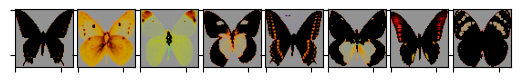

In [15]:
idxes = plot_images(batch)

#### pretrained VAE to encode pixels to latent space

In [16]:
#Load the VAE
# We load with requires_grad_(False) because we won't be training the autoencoder
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").cuda().requires_grad_(False)

# Encode a batch of images
# Note that the encoded batch has 4 channels and not 3
encoded_batch = vae.encode(batch).latent_dist.mean*0.18125

# Decode an encoded batch

decoded_batch = vae.decode(encoded_batch*5.489)['sample']

In [17]:
type(encoded_batch), encoded_batch.shape

(torch.Tensor, torch.Size([32, 4, 8, 8]))

In [18]:
type(decoded_batch), decoded_batch.shape

(torch.Tensor, torch.Size([32, 3, 64, 64]))

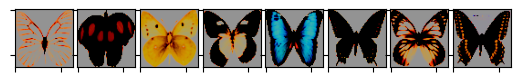

In [19]:
#images before
idxes = plot_images(batch)

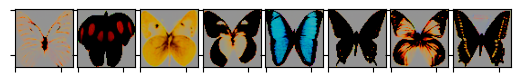

array([30, 21, 19, 27, 17,  8, 26,  4])

In [20]:
#plotting same images after doing encoding - decoding through VAE
plot_images(decoded_batch, idxToDsiplay=idxes)

### Model

#### model-utility

In [21]:
class Swish(Module):
    """
    Swish actiavation function
    """

    def forward(self, x):
        return x * torch.sigmoid(x)

In [22]:
class TimeEmbedding(nn.Module):
    """
    ### Embeddings for $t$
    """

    def __init__(self, n_channels: int):
        """
        * `n_channels` is the number of dimensions in the embedding
        """
        super().__init__()
        self.n_channels = n_channels
        # First linear layer
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Activation
        self.act = Swish()
        # Second linear layer
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        # Create sinusoidal position embeddings
        # where $d$ is `half_dim`
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        # Transform with the MLP
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        #
        return emb

In [23]:
class ResidualBlock(Module):
    """
    ### Residual block

    A residual block has two convolution layers with group normalization.
    Each resolution is processed with two residual blocks.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int,
                 n_groups: int = 32, dropout: float = 0.1):
        """
        * `in_channels` is the number of input channels
        * `out_channels` is the number of input channels
        * `time_channels` is the number channels in the time step ($t$) embeddings
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        * `dropout` is the dropout rate
        """
        super().__init__()
        # Group normalization and the first convolution layer
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # Group normalization and the second convolution layer
        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        # Linear layer for time embeddings
        self.time_emb = nn.Linear(time_channels, out_channels)
        self.time_act = Swish()

        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # First convolution layer
        h = self.conv1(self.act1(self.norm1(x)))
        # Add time embeddings
        h += self.time_emb(self.time_act(t))[:, :, None, None]
        # Second convolution layer
        h = self.conv2(self.dropout(self.act2(self.norm2(h))))

        # Add the shortcut connection and return
        return h + self.shortcut(x)

In [24]:
class AttentionBlock(Module):
    """
    ### Attention block

    This is similar to [transformer multi-head attention](../../transformers/mha.html).
    """

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
        """
        * `n_channels` is the number of channels in the input
        * `n_heads` is the number of heads in multi-head attention
        * `d_k` is the number of dimensions in each head
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels
        # Normalization layer
        self.norm = nn.GroupNorm(n_groups, n_channels)
        # Projections for query, key and values
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        # Linear layer for final transformation
        self.output = nn.Linear(n_heads * d_k, n_channels)
        # Scale for dot-product attention
        self.scale = d_k ** -0.5
        #
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        # Get shape
        batch_size, n_channels, height, width = x.shape
        # Change `x` to shape `[batch_size, seq, n_channels]`
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # Get query, key, and values (concatenated) and shape it to `[batch_size, seq, n_heads, 3 * d_k]`
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        # Split query, key, and values. Each of them will have shape `[batch_size, seq, n_heads, d_k]`
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        # Calculate scaled dot-product $\frac{Q K^\top}{\sqrt{d_k}}$
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        # Softmax along the sequence dimension $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
        attn = attn.softmax(dim=2)
        # Multiply by values
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        # Reshape to `[batch_size, seq, n_heads * d_k]`
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        # Transform to `[batch_size, seq, n_channels]`
        res = self.output(res)

        # Add skip connection
        res += x

        # Change to shape `[batch_size, in_channels, height, width]`
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        #
        return res

In [25]:
class DownBlock(Module):
    """
    ### Down block

    This combines `ResidualBlock` and `AttentionBlock`. These are used in the first half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class UpBlock(Module):
    """
    ### Up block

    This combines `ResidualBlock` and `AttentionBlock`. These are used in the second half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class MiddleBlock(Module):
    """
    ### Middle block

    It combines a `ResidualBlock`, `AttentionBlock`, followed by another `ResidualBlock`.
    This block is applied at the lowest resolution of the U-Net.
    """

    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


class Upsample(nn.Module):
    """
    ### Scale up the feature map by $2 \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class Downsample(nn.Module):
    """
    ### Scale down the feature map by $\frac{1}{2} \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)

#### u-net

In [26]:
class UNet(Module):
    """
    ## U-Net
    """

    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[int]] = (False, False, True, True),
                 n_blocks: int = 2):
        """
        * `image_channels` is the number of channels in the image. $3$ for RGB.
        * `n_channels` is number of channels in the initial feature map that we transform the image into
        * `ch_mults` is the list of channel numbers at each resolution. The number of channels is `ch_mults[i] * n_channels`
        * `is_attn` is a list of booleans that indicate whether to use attention at each resolution
        * `n_blocks` is the number of `UpDownBlocks` at each resolution
        """
        super().__init__()

        # Number of resolutions
        n_resolutions = len(ch_mults)

        # Project image into feature map
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

        # Time embedding layer. Time embedding has `n_channels * 4` channels
        self.time_emb = TimeEmbedding(n_channels * 4)

        # #### First half of U-Net - decreasing resolution
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        for i in range(n_resolutions):
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            # Down sample at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        # #### Second half of U-Net - increasing resolution
        up = []
        # Number of channels
        in_channels = out_channels
        # For each resolution
        for i in reversed(range(n_resolutions)):
            # `n_blocks` at the same resolution
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            # Final block to reduce the number of channels
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            # Up sample at all resolutions except last
            if i > 0:
                up.append(Upsample(in_channels))

        # Combine the set of modules
        self.up = nn.ModuleList(up)

        # Final normalization and convolution layer
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size]`
        """

        # Get time-step embeddings
        t = self.time_emb(t)

        # Get image projection
        x = self.image_proj(x)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, t)

        # Second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                #
                x = m(x, t)

        # Final normalization and convolution
        return self.final(self.act(self.norm(x)))

In [27]:
t = torch.randint(0, 10, (batch.shape[0],), device=batch.device, dtype=torch.long)
type(t), t.shape, t.device, torch.min(t), torch.max(t)

(torch.Tensor,
 torch.Size([32]),
 device(type='cuda', index=0),
 tensor(0, device='cuda:0'),
 tensor(9, device='cuda:0'))

In [28]:
model = UNet(image_channels=4).to(DEVICE)
output = model(encoded_batch, t)
type(output), output.shape, output.device, torch.min(output), torch.max(output)

(torch.Tensor,
 torch.Size([32, 4, 8, 8]),
 device(type='cuda', index=0),
 tensor(-1.2078, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(1.4014, device='cuda:0', grad_fn=<MaxBackward1>))

In [29]:
decoded_output = vae.decode(output*5.489)['sample']
type(decoded_output), decoded_output.shape, decoded_output.device, torch.min(decoded_output), torch.max(decoded_output)

(torch.Tensor,
 torch.Size([32, 3, 64, 64]),
 device(type='cuda', index=0),
 tensor(-1.3014, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(1.3024, device='cuda:0', grad_fn=<MaxBackward1>))

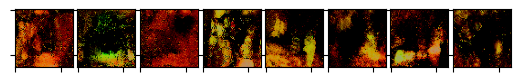

In [30]:
plot_images(decoded_output, idxToDsiplay=idxes);

### Diffusion Process

In [31]:
class DenoiseDiffusion:
    """
    ## Denoise Diffusion
    """

    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        """
        * `eps_model` is $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$ model
        * `n_steps` is $t$
        * `device` is the device to place constants on
        """
        super().__init__()
        self.eps_model = eps_model
        self.device = device

        # Create $\beta_1, \dots, \beta_T$ linearly increasing variance schedule
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)

        # $\alpha_t = 1 - \beta_t$
        self.alpha = 1. - self.beta
        # $\bar\alpha_t = \prod_{s=1}^t \alpha_s$
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        # $T$
        self.n_steps = n_steps
        # $\sigma^2 = \beta$
        self.sigma2 = self.beta

    def q_xt_x0(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        #### Get $q(x_t|x_0)$ distribution

        \begin{align}
        q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
        \end{align}
        """

        # [gather](utils.html) $\alpha_t$ and compute $\sqrt{\bar\alpha_t} x_0$
        mean = gather(self.alpha_bar, t) ** 0.5 * x0
        # $(1-\bar\alpha_t) \mathbf{I}$
        var = 1 - gather(self.alpha_bar, t)
        #
        return mean, var

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):
        """
        #### Sample from $q(x_t|x_0)$

        \begin{align}
        q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
        \end{align}
        """

        # $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
        if eps is None:
            eps = torch.randn_like(x0)

        # get $q(x_t|x_0)$
        mean, var = self.q_xt_x0(x0, t)
        # Sample from $q(x_t|x_0)$
        return mean + (var ** 0.5) * eps

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor):
        """
        #### Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$

        \begin{align}
        \textcolor{lightgreen}{p_\theta}(x_{t-1} | x_t) &= \mathcal{N}\big(x_{t-1};
        \textcolor{lightgreen}{\mu_\theta}(x_t, t), \sigma_t^2 \mathbf{I} \big) \\
        \textcolor{lightgreen}{\mu_\theta}(x_t, t)
          &= \frac{1}{\sqrt{\alpha_t}} \Big(x_t -
            \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)
        \end{align}
        """

        # $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$
        eps_theta = self.eps_model(xt, t)
        # [gather](utils.html) $\bar\alpha_t$
        alpha_bar = gather(self.alpha_bar, t)
        # $\alpha_t$
        alpha = gather(self.alpha, t)
        # $\frac{\beta}{\sqrt{1-\bar\alpha_t}}$
        eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
        # $$\frac{1}{\sqrt{\alpha_t}} \Big(x_t -
        #      \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)$$
        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        # $\sigma^2$
        var = gather(self.sigma2, t)

        # $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
        eps = torch.randn(xt.shape, device=xt.device)
        # Sample
        return mean + (var ** .5) * eps

    def sample(self, n_samples, image_channels, image_size):
        """
        ### Sample images
        """
        with torch.no_grad():
            # $x_T \sim p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$
            x = torch.randn([n_samples, image_channels, image_size, image_size],
                            device=self.device)

            # Remove noise for $T$ steps
            for t_ in range(self.n_steps):
                # $t$
                t = self.n_steps - t_ - 1
                # Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$
                x = self.p_sample(x, x.new_full((n_samples,), t, dtype=torch.long))

            # Log samples
            return x

    def loss(self, x0: torch.Tensor, noise: Optional[torch.Tensor] = None):
        """
        #### Simplified Loss

        $$L_{\text{simple}}(\theta) = \mathbb{E}_{t,x_0, \epsilon} \Bigg[ \bigg\Vert
        \epsilon - \textcolor{lightgreen}{\epsilon_\theta}(\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon, t)
        \bigg\Vert^2 \Bigg]$$
        """
        # Get batch size
        batch_size = x0.shape[0]
        # Get random $t$ for each sample in the batch
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)

        # $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
        if noise is None:
            noise = torch.randn_like(x0)

        # Sample $x_t$ for $q(x_t|x_0)$
        xt = self.q_sample(x0, t, eps=noise)
        # Get $\textcolor{lightgreen}{\epsilon_\theta}(\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon, t)$
        eps_theta = self.eps_model(xt, t)

        # MSE loss
        return F.huber_loss(noise, eps_theta)

### Training

In [32]:
CHECKPOINT_PATH = '/kaggle/input/checkpoint/checkpoint2-2'
checkpoint = torch.load(CHECKPOINT_PATH)
checkpoint['epoch']

60

In [33]:
NUM_EPOCHS = 15
LR = 0.00001

train_dataloader = dataloader_
model = UNet(image_channels=4).to(DEVICE)
model.load_state_dict(checkpoint['model_state_dict']) #loading pretrained weights

diffusion = DenoiseDiffusion(model, 100, DEVICE) #diffuser

optimizer = torch.optim.Adam(model.parameters(), LR, weight_decay=1e-6)

In [34]:
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                   factor=0.8, patience=2,
                                                   threshold=0.02, threshold_mode='rel',
                                                   cooldown=1, min_lr=0.000001,
                                                   eps=1e-08, verbose=True)

In [35]:
import time
import tqdm.notebook as tqdm

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

-------- Sampled Images -------


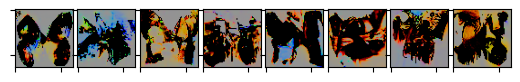

Epoch 0 completed in 0m 21s with total training loss 5.360345467925072


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 1 completed in 0m 13s with total training loss 5.263459652662277


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 2 completed in 0m 13s with total training loss 5.219684883952141


  0%|          | 0/31 [00:00<?, ?it/s]

-------- Sampled Images -------


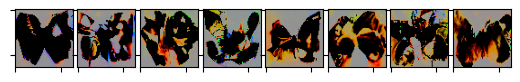

Epoch 3 completed in 0m 18s with total training loss 5.063616514205933


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 4 completed in 0m 13s with total training loss 5.263090714812279


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5 completed in 0m 14s with total training loss 5.264304742217064


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 8.0000e-06.
-------- Sampled Images -------


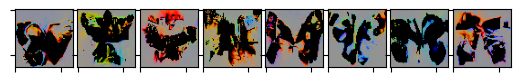

Epoch 6 completed in 0m 18s with total training loss 5.203025594353676


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 7 completed in 0m 14s with total training loss 5.424287781119347


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 8 completed in 0m 13s with total training loss 5.253847390413284


  0%|          | 0/31 [00:00<?, ?it/s]

-------- Sampled Images -------


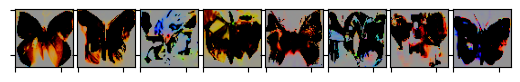

Epoch 9 completed in 0m 18s with total training loss 5.219756677746773


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 00011: reducing learning rate of group 0 to 6.4000e-06.
Epoch 10 completed in 0m 13s with total training loss 5.166918411850929


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 11 completed in 0m 13s with total training loss 5.140116274356842


  0%|          | 0/31 [00:00<?, ?it/s]

-------- Sampled Images -------


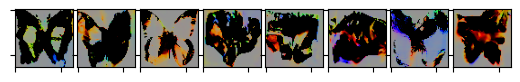

Epoch 12 completed in 0m 17s with total training loss 5.25592640042305


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 13 completed in 0m 14s with total training loss 5.450135245919228


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 00015: reducing learning rate of group 0 to 5.1200e-06.
-------- Sampled Images -------


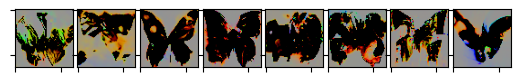

Epoch 14 completed in 0m 18s with total training loss 5.3958915919065475


In [36]:
plot_after_k = 3
running_metrics = {}
running_metrics.setdefault('train_loss', [])
for epoch in tqdm.trange(0, NUM_EPOCHS):
    since = time.time()
    epoch_loss = 0.0

    #Training mode
    model.train()
    tqdm_loader = tqdm.tqdm(train_dataloader)
    for batch in tqdm_loader:
        batch = batch['images']
        tqdm_loader.set_description(f"Training Epoch {epoch}")
        encoded_batch = vae.encode(batch.to(DEVICE)).latent_dist.mean*0.18125
#         optimizer.zero_grad() # zero the parameter gradients
        # track history if only in train
        with torch.set_grad_enabled(True):
            optimizer.zero_grad() # zero the parameter gradients
            loss = diffusion.loss(encoded_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        # statistics
        epoch_loss += loss.item()
        tqdm_loader.set_postfix(training_loss=loss.item())
    
    # lr sheduling after epoch
    lr_scheduler.step(epoch_loss)
    running_metrics['train_loss'].append(epoch_loss)
    gc.collect()    
    #plotting after k epochs
    if (epoch%plot_after_k ==0 or (epoch==NUM_EPOCHS-1)):
        print('-------- Sampled Images -------')
        sample_ = diffusion.sample(10, image_channels = encoded_batch.shape[1], image_size = encoded_batch.shape[2])
        plot_images(vae.decode(sample_*5.489)['sample'])
    time_elapsed = time.time() - since
    print(f"Epoch {epoch} completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s with total training loss {running_metrics['train_loss'][-1]}")

#### saving checkpoint

In [37]:
# first time saving - uncomment only to save for checkpoint for the first time
# checkpoint_to_save = {
#             'epoch': NUM_EPOCHS,
#             'model_state_dict': model.state_dict(),
#             'running_metrics': running_metrics,
#             }
# PATH = '/kaggle/working/checkpoint2-1'
# torch.save(checkpoint_to_save, PATH)

In [38]:
PREV_EPOCHS = checkpoint['epoch']
PREV_RUNNING_METRICS = checkpoint['running_metrics']
PREV_EPOCHS, len(PREV_RUNNING_METRICS['train_loss'])

(60, 60)

In [39]:
NUM_EPOCHS_TO_SAVE = PREV_EPOCHS + NUM_EPOCHS
RUNNING_METRICS_TO_SAVE = {'train_loss':PREV_RUNNING_METRICS['train_loss'] + running_metrics['train_loss']}

NUM_EPOCHS_TO_SAVE, len(RUNNING_METRICS_TO_SAVE['train_loss'])

(75, 75)

In [40]:
checkpoint_to_save = {
            'epoch': NUM_EPOCHS_TO_SAVE,
            'model_state_dict': model.state_dict(),
            'running_metrics': RUNNING_METRICS_TO_SAVE,
            }
PATH = '/kaggle/working/checkpoint2-final'

In [41]:
torch.save(checkpoint_to_save, PATH)

#### Inference

In [42]:
INFERENCE_CKP_PATH = '/kaggle/working/checkpoint2-final'
INFERENCE_CKP = torch.load(INFERENCE_CKP_PATH)

In [43]:
inference_model = UNet(image_channels=4).to(DEVICE)
inference_model.load_state_dict(INFERENCE_CKP['model_state_dict'])
inference_diffusion = DenoiseDiffusion(inference_model, 300, DEVICE) #diffuser

In [44]:
sample_ = inference_diffusion.sample(10, image_channels = encoded_batch.shape[1], image_size = encoded_batch.shape[2])
sample_img = vae.decode(sample_*5.489)['sample']
sample_img.shape

torch.Size([10, 3, 64, 64])

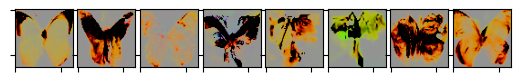

array([9, 7, 5, 3, 8, 0, 4, 1])

In [45]:
plot_images(sample_img)

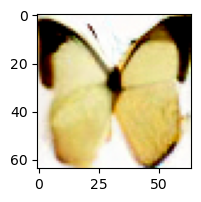

In [51]:
plt.figure(figsize = (2, 2))
plt.imshow(sample_img[9].permute(1, 2, 0).detach().cpu().numpy())

Text(0.5, 0, 'epochs')

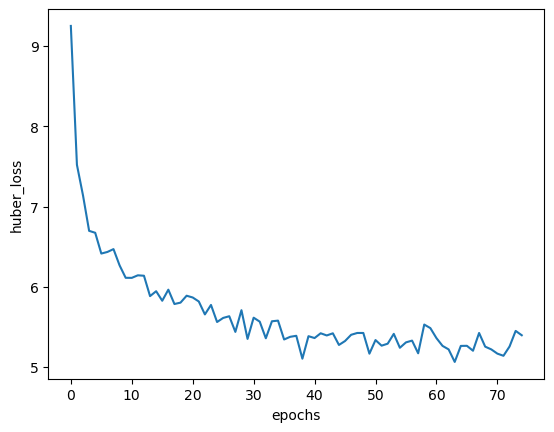

In [54]:
train_loss = INFERENCE_CKP['running_metrics']['train_loss']
plt.plot(train_loss)
plt.ylabel('huber_loss')
plt.xlabel('epochs')